In [1]:
import os
from pathlib import Path
import shutil
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize
from tqdm import tqdm
from pytorch_fid.fid_score import calculate_fid_given_paths

from models import Generator_28
from utils import show_tensor_images, save_image, compute_fid

device = 'cuda'
num_avail_cpus = len(os.sched_getaffinity(0))

path_data = '../../data'


## MNIST data to .png

In [2]:
# mnist_train = datasets.MNIST(
#     root=path_data,
#     train=True,
#     download=False,
# )
# mnist_test = datasets.MNIST(
#     root=path_data,
#     train=False,
#     download=False,
# )

# mnist_train_imgs = mnist_train.data[:, None, :, :] / 255 # /255 same as ToTensor()
# mnist_train_imgs = (mnist_train_imgs - 0.5) / 0.5 # same as Normalize((0.5,), (0.5,))

# mnist_test_imgs = mnist_test.data[:, None, :, :] / 255 # /255 same as ToTensor()
# mnist_test_imgs = (mnist_test_imgs - 0.5) / 0.5 # same as Normalize((0.5,), (0.5,))

# for i in tqdm(range(len(mnist_train_imgs))):
#     save_image(mnist_train_imgs[i], path_data+f'/MNIST/png/train/{i}.png')

# for i in tqdm(range(len(mnist_test_imgs))):
#     save_image(mnist_test_imgs[i], path_data+f'/MNIST/png/test/{i}.png')

## MNIST dataset statistics to .npz (to load when computing FID)

In [3]:
# from pytorch_fid.fid_score import save_fid_stats

# path_mnist_png = path_data+f'/MNIST/png/test'
# path_mnist_npz = path_data+f'/MNIST/stats_test.npz'

# save_fid_stats([path_mnist_png, path_mnist_npz], 64, device, 2048, 1)


## Load Generator

In [4]:
# fname = './models/DCGAN_corrupted_MNIST_weights_20211208_1838.pth'
# fname = './models/DCGAN_MNIST_weights_20211208_1819.pth' # FID 14.15_WRONG - 10.59, 10.35, 10.44, 10.34
fname = './models/DCGAN_conditional_MNIST_weights_20211208_1741.pth' # FID 9.02_WRONG 5.02, 5.14

conditional = True if 'conditional' in fname else False

z_dim = 64
n_classes = 10 if conditional else 0
generator_input_dim = z_dim + n_classes

gen = Generator_28(generator_input_dim).to(device)
gen.load_state_dict(torch.load(fname))
gen.eval()

Generator_28(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(74, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
      (1): Tanh()
    )
  )
)

In [5]:
%%time
path_mnist_png = path_data+f'/MNIST/png/train'
fid = compute_fid(gen, conditional, n_classes, path_mnist_png)

Generate and save images: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


Compute FID


100%|██████████| 79/79 [00:17<00:00,  4.58it/s]


FID: 4.92
CPU times: user 8min 30s, sys: 8min 55s, total: 17min 26s
Wall time: 5min 52s


In [6]:
%%time
path_mnist_npz = path_data+f'/MNIST/stats_train.npz'
fid = compute_fid(gen, conditional, n_classes, path_mnist_npz)

Generate and save images: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


Compute FID


100%|██████████| 79/79 [00:17<00:00,  4.56it/s]


FID: 5.04
CPU times: user 5min 26s, sys: 6min 17s, total: 11min 44s
Wall time: 3min 13s


## Generate and save images

Generate and save images: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


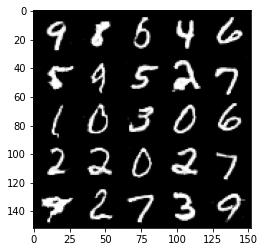

In [5]:
# nb_images_to_generate = 10000
# batch_size = nb_images_to_generate
# noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
# label = torch.randint(0, 10, (batch_size, ))

# if conditional:
#     one_hot_labels = nn.functional.one_hot(label.to(device), n_classes)[:,:,None,None]
#     noise = torch.cat((noise.float(), one_hot_labels.float()), dim=1)
# with torch.no_grad():
#     fake = gen(noise).detach().cpu()

# show_tensor_images(fake) # show a few images

# Path('/d/alecoz/projects/data/.temp').mkdir() # create directory
# for i in tqdm(range(len(fake))):
#     vutils.save_image(fake[i], f'/d/alecoz/projects/data/.temp/{i}.png')
    
nb_images_to_generate = 10000
batch_size = 1024

path_temp = Path('./temp')
if path_temp.exists(): shutil.rmtree(path_temp)
path_temp.mkdir() # create temporary directory

img_idx = 0
nb_batchs = nb_images_to_generate // batch_size
for i in tqdm(range(nb_batchs + 1), 'Generate and save images'):

    if i == nb_batchs: batch_size = nb_images_to_generate % batch_size # handle last batch

    # Create inputs
    noise = torch.randn(batch_size, gen.z_dim, 1, 1, device=device)

    if conditional:
        label = torch.randint(0, n_classes, (batch_size, ))
        one_hot_labels = nn.functional.one_hot(label.to(device), n_classes)[:,:,None,None]
        noise = torch.cat((noise[:, :gen.z_dim-n_classes, :, :].float(), one_hot_labels.float()), dim=1)

    # Generate images
    with torch.no_grad():
        fake = gen(noise).detach().cpu()

    # Save images in temporary folder
    for fake_idx in range(len(fake)):
        save_image(fake[fake_idx], path_temp/f'{img_idx}.png')
        img_idx += 1
        
show_tensor_images(fake) # show a few images

## Compute FID
Baseline (FID of MNIST train vs MNIST test): 1.005

In [6]:
fid = calculate_fid_given_paths(
    paths=[path_data+f'/MNIST/png/train', str(path_temp)], 
    batch_size=50,
    device='cuda',
    dims=2048,
    num_workers=min(num_avail_cpus, 8))
print('FID: {:.2f}'.format(fid))

# shutil.rmtree('/d/alecoz/projects/data/.temp') # remove temporary directory
# shutil.rmtree(path_temp) # remove temporary directory

100%|██████████| 200/200 [00:13<00:00, 15.02it/s]


FID: 5.14


In [7]:
fid = calculate_fid_given_paths(
    paths=[path_data+f'/MNIST/png/train', path_data+f'/MNIST/png/test'], 
    batch_size=50,
    device='cuda',
    dims=2048,
    num_workers=min(num_avail_cpus, 8))
print('FID: {:.2f}'.format(fid))

# shutil.rmtree('/d/alecoz/projects/data/.temp') # remove temporary directory
# shutil.rmtree(path_temp) # remove temporary directory

100%|██████████| 200/200 [00:13<00:00, 15.09it/s]


FID: 1.01


In [8]:
fid

1.0050802249229775